# Model A

Model A is trained using random time points for each patient. We first train this model, then evaluate it on a separate dataset with data extracted at fixed lead times from mortality for the patients who died in-hospital.

In [1]:
from __future__ import print_function

# Import libraries
import numpy as np
import pandas as pd
import matplotlib
import sklearn
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties # for unicode fonts
import psycopg2
import sys
import datetime as dt
import mp_utils as mp

from collections import OrderedDict

# used to print out pretty pandas dataframes
from IPython.display import display, HTML

from sklearn.pipeline import Pipeline

# used to impute mean for data and standardize for computational stability
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# logistic regression is our favourite model ever
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV # l2 regularized regression
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier

# used to calculate AUROC/accuracy
from sklearn import metrics

# used to create confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_score

# gradient boosting - must download package https://github.com/dmlc/xgboost
import xgboost as xgb

# default colours for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']

%matplotlib inline

# below config used on pc70
sqluser = 'alistairewj'
dbname = 'mimic'
schema_name = 'mimiciii'
query_schema = 'SET search_path to public,' + schema_name + ';'

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [68]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)

In [69]:
# exclusion criteria:
#   - less than 16 years old
#   - stayed in the ICU less than 4 hours
#   - never have any chartevents data (i.e. likely administrative error)
query = query_schema + \
"""
select 
    subject_id, hadm_id, icustay_id
from mp_cohort
where excluded = 0
"""
co = pd.read_sql_query(query,con)

# extract static vars into a separate dataframe
df_static = pd.read_sql_query(query_schema + 'select * from mp_static_data', con)
#for dtvar in ['intime','outtime','deathtime']:
#    df_static[dtvar] = pd.to_datetime(df_static[dtvar])

vars_static = [u'is_male', u'emergency_admission', u'age',
               # services
               u'service_any_noncard_surg',
               u'service_any_card_surg',
               u'service_cmed',
               u'service_traum',
               u'service_nmed',
               # ethnicities
               u'race_black',u'race_hispanic',u'race_asian',u'race_other',
               # phatness
               u'height', u'weight', u'bmi']

In [4]:
# get ~5 million rows containing data from errbody
# this takes a little bit of time to load into memory (~2 minutes)

# %%time results
# CPU times: user 42.8 s, sys: 1min 3s, total: 1min 46s
# Wall time: 2min 7s

df = pd.read_sql_query(query_schema + 'select * from mp_data', con)
df.drop('subject_id',axis=1,inplace=True)
df.drop('hadm_id',axis=1,inplace=True)
df.sort_values(['icustay_id','hr'],axis=0,ascending=True,inplace=True)
print(df.shape)

(6397941, 54)


In [5]:
# get death information
df_death = pd.read_sql_query(query_schema + """
select 
co.icustay_id
, ceil(extract(epoch from (co.outtime - co.intime))/60.0/60.0) as dischtime_hours
, ceil(extract(epoch from (adm.deathtime - co.intime))/60.0/60.0) as deathtime_hours
, case when adm.deathtime is null then 0 else 1 end as death
from mp_cohort co
inner join admissions adm
on co.hadm_id = adm.hadm_id
where co.excluded = 0
""", con)

## Create dataframe with design matrix

Takes ~2 seconds.

In [86]:
reload(mp)
time_dict = mp.generate_times(df_death, T=4, seed=111)
df_data = mp.get_design_matrix(df, time_dict, W=8, W_extra=24)

# load the data into a numpy array

# first, the data from static vars from df_static
X = df_data.merge(df_static.set_index('icustay_id')[vars_static], how='left', left_index=True, right_index=True)
# next, add in the outcome: death in hospital
X = X.merge(df_death.set_index('icustay_id')[['death']], left_index=True, right_index=True)

# convert to numpy data (assumes target, death, is the last column)
X = X.values
y = X[:,-1]
X = X[:,0:-1]
X_header = vars_static + [x for x in df_data.columns.values]

## Model 1: Using random time segments

The above reported cross-validation performance in a variety of settings. We're also interested in *evaluating* the same model in the various settings. That is, training a model using random offsets, and then evaluating how it performs 4 hours before death, 8 hours, etc.

In [88]:
models = {'xgb': xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05),
          'lasso': LassoCV(cv=5,fit_intercept=True,normalize=True,max_iter=10000),
          'logreg': LogisticRegression(fit_intercept=True),
          'rf': RandomForestClassifier()
         }

In [89]:
# Rough timing info:
#     rf - 3 seconds per fold
#    xgb - 30 seconds per fold
# logreg - 4 seconds per fold
#  lasso - 8 seconds per fold

# create k-fold indices
K = 5 # number of folds
idxK = np.random.permutation(X.shape[0])
idxK = np.mod(idxK,K)

mdl_val = dict()
results_val = dict()

for mdl in models:
    print('=============== {} ==============='.format(mdl))
    mdl_val[mdl] = list()
    results_val[mdl] = list() # initialize list for scores

    if mdl == 'xgb':
        # no pre-processing of data necessary for xgb
        estimator = Pipeline([(mdl, models[mdl])])

    else:
        estimator = Pipeline([("imputer", Imputer(missing_values='NaN',
                                          strategy="mean",
                                          axis=0)),
                      ("scaler", StandardScaler()),
                      (mdl, models[mdl])]) 

    for k in range(K):
        # train the model using all but the kth fold
        curr_mdl = estimator.fit(X[idxK != k, :],y[idxK != k])

        # get prediction on this dataset
        if mdl == 'lasso':
            curr_prob = curr_mdl.predict(X[idxK == k, :])
        else:
            curr_prob = curr_mdl.predict_proba(X[idxK == k, :])
            curr_prob = curr_prob[:,1]

        # calculate score (AUROC)
        curr_score = metrics.roc_auc_score(y[idxK == k], curr_prob)

        # add score to list of scores
        results_val[mdl].append(curr_score)

        # save the current model
        mdl_val[mdl].append(curr_mdl)

        print('{} - Finished fold {} of {}. AUROC {:0.3f}.'.format(dt.datetime.now(), k+1, K, curr_score))

=============== rf ===============
2017-02-21 15:40:46.823810 - Finished fold 1 of 5. AUROC 0.844.
2017-02-21 15:40:48.994457 - Finished fold 2 of 5. AUROC 0.849.
2017-02-21 15:40:51.049168 - Finished fold 3 of 5. AUROC 0.850.
2017-02-21 15:40:53.024827 - Finished fold 4 of 5. AUROC 0.852.
2017-02-21 15:40:55.060977 - Finished fold 5 of 5. AUROC 0.855.
=============== xgb ===============
2017-02-21 15:41:09.828185 - Finished fold 1 of 5. AUROC 0.911.
2017-02-21 15:41:22.608824 - Finished fold 2 of 5. AUROC 0.907.
2017-02-21 15:41:37.195103 - Finished fold 3 of 5. AUROC 0.915.
2017-02-21 15:41:47.959887 - Finished fold 4 of 5. AUROC 0.907.
2017-02-21 15:41:59.678600 - Finished fold 5 of 5. AUROC 0.915.
=============== logreg ===============
2017-02-21 15:42:02.946626 - Finished fold 1 of 5. AUROC 0.889.
2017-02-21 15:42:06.246381 - Finished fold 2 of 5. AUROC 0.888.
2017-02-21 15:42:09.878346 - Finished fold 3 of 5. AUROC 0.890.
2017-02-21 15:42:12.548381 - Finished fold 4 of 5. AUROC 0

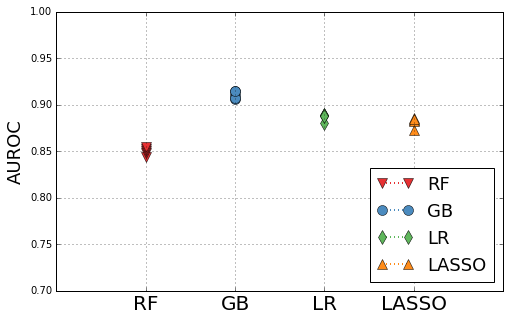

In [95]:
pretty_labels = {'xgb': 'GB', 'rf': 'RF', 'logreg': 'LR', 'lasso': 'LASSO'}
plt.figure(figsize=[8,5])
for m, mdl in enumerate(results_val):
    curr_score = results_val[mdl]
    plt.plot(m*np.ones(len(curr_score)), curr_score,
            marker=marker[m], color=col[m],
            markersize=10, linewidth=2, linestyle=':',
            label=pretty_labels[mdl])

plt.ylabel('AUROC',fontsize=18)
plt.xlim([-1,m+1])
plt.ylim([0.7,1.0])
plt.grid()
plt.gca().set_xticks(np.linspace(0,m,m+1))
plt.gca().set_xticklabels([pretty_labels[x] for x in results_val.keys()])
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 

plt.legend(loc='lower right',fontsize=18)
plt.show()

In [98]:
# experiment elements contain a list: [seed, W (window size), T_to_death]
experiments = OrderedDict([['base', [473010,8,None]],
               ['24hr', [585794,24,None]],
               ['Td=00', [724311,8,0]],
               ['Td=04', [952227,8,4]],
               ['Td=08', [721297,8,8]],
               ['Td=16', [968879,8,16]],
               ['Td=24', [608972,8,24]],
               ['24hr Td=00', [34741,24,0]],
               ['24hr Td=04', [34319,24,4]],
               ['24hr Td=08', [95467,24,8]],
               ['24hr Td=16', [85349,24,16]],
               ['24hr Td=24', [89642,24,24]]
                          ])

# fuzzyness to allow deathtime to be a little bit after discharge time
death_epsilon=2
X_all = dict()
y_all = dict()
iid_all = dict()
pred_all = dict()
time_all = dict()
X_header_all = dict()

for e in experiments:
    params = experiments[e]
    time_all[e] = mp.generate_times(df_death, seed=params[0], T=None, T_to_death=params[2])
    df_data = mp.get_design_matrix(df, time_all[e], W=params[1], W_extra=24)
    
    # load the data into a numpy array
        
    # Add in static vars from df_static
    X = df_data.merge(df_static.set_index('icustay_id')[vars_static],
                      how='left', left_index=True, right_index=True)
    
    
    if params[2] is not None:
        df_tmp = df_death[['icustay_id','death','dischtime_hours', 'deathtime_hours']].copy()
        df_tmp['death_in_icu'] = (df_tmp['deathtime_hours']<=(df_tmp['dischtime_hours']+params[2]+death_epsilon)).astype(float)
        X = X.merge(df_tmp[['icustay_id','death_in_icu']].set_index('icustay_id'),
                          left_index=True, right_index=True)
    else:
        X = X.merge(df_death[['icustay_id','death']].set_index('icustay_id'),
                          left_index=True, right_index=True)

    iid_all[e] = X.index.values
    X = X.values
    y_all[e] = X[:,-1]
    X_all[e] = X[:,0:-1]
    
    X_header_all[e] = df_data.columns

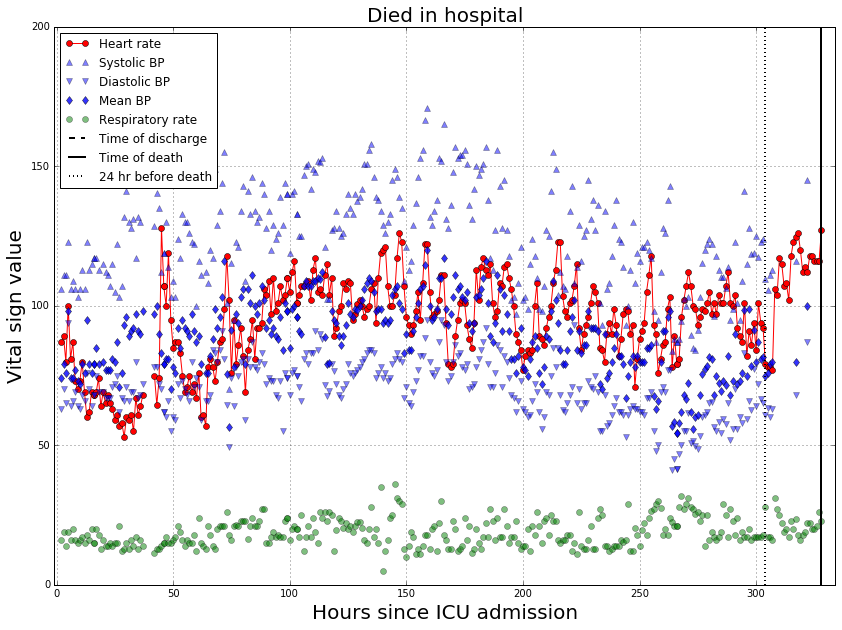

In [92]:
mp.plot_vitals(df, iid=200033, df_death=df_death)

## Train/evaluate model using a variety of data extraction windows

In [99]:
K = 5 # number of folds
results_all = dict()
mdl_all = dict()

for e in experiments:
    print('=============== {} ==============='.format(e))
    
    mdl_all[e] = dict( )
    results_all[e] = dict()
    
    X = X_all[e]
    y = y_all[e]
    
    # create k-fold indices
    idxK = np.random.permutation(X.shape[0])
    idxK = np.mod(idxK,K)
    
    for mdl in models:
        print('{} ...'.format(mdl))
        mdl_all[e][mdl] = list()
        results_all[e][mdl] = list() # initialize list for scores

        if mdl == 'xgb':
            # no pre-processing of data necessary for xgb
            estimator = Pipeline([(mdl, models[mdl])])

        else:
            estimator = Pipeline([("imputer", Imputer(missing_values='NaN',
                                              strategy="mean",
                                              axis=0)),
                          ("scaler", StandardScaler()),
                          (mdl, models[mdl])]) 

        for k in range(K):
            # train the model using all but the kth fold
            curr_mdl = estimator.fit(X[idxK != k, :],y[idxK != k])

            # get prediction on this dataset
            if mdl == 'lasso':
                curr_prob = curr_mdl.predict(X[idxK == k, :])
            else:
                curr_prob = curr_mdl.predict_proba(X[idxK == k, :])
                curr_prob = curr_prob[:,1]

            # calculate score (AUROC)
            curr_score = metrics.roc_auc_score(y[idxK == k], curr_prob)

            # add score to list of scores
            results_all[e][mdl].append(curr_score)

            # save the current model
            mdl_all[e][mdl].append(curr_mdl)

            print('{} - Finished fold {} of {}. AUROC {:0.3f}.'.format(dt.datetime.now(), k+1, K, curr_score))

=============== base ===============
rf ...
2017-02-21 15:58:57.857710 - Finished fold 1 of 5. AUROC 0.905.
2017-02-21 15:59:00.032561 - Finished fold 2 of 5. AUROC 0.906.
2017-02-21 15:59:02.006773 - Finished fold 3 of 5. AUROC 0.894.
2017-02-21 15:59:04.074479 - Finished fold 4 of 5. AUROC 0.900.
2017-02-21 15:59:06.092083 - Finished fold 5 of 5. AUROC 0.893.
xgb ...
2017-02-21 15:59:18.314629 - Finished fold 1 of 5. AUROC 0.955.
2017-02-21 15:59:30.368276 - Finished fold 2 of 5. AUROC 0.952.
2017-02-21 15:59:43.821222 - Finished fold 3 of 5. AUROC 0.952.
2017-02-21 15:59:58.177409 - Finished fold 4 of 5. AUROC 0.953.
2017-02-21 16:00:09.815215 - Finished fold 5 of 5. AUROC 0.951.
logreg ...
2017-02-21 16:00:12.402550 - Finished fold 1 of 5. AUROC 0.891.
2017-02-21 16:00:15.595639 - Finished fold 2 of 5. AUROC 0.884.
2017-02-21 16:00:18.382601 - Finished fold 3 of 5. AUROC 0.891.
2017-02-21 16:00:21.742612 - Finished fold 4 of 5. AUROC 0.891.
2017-02-21 16:00:25.692240 - Finished fol

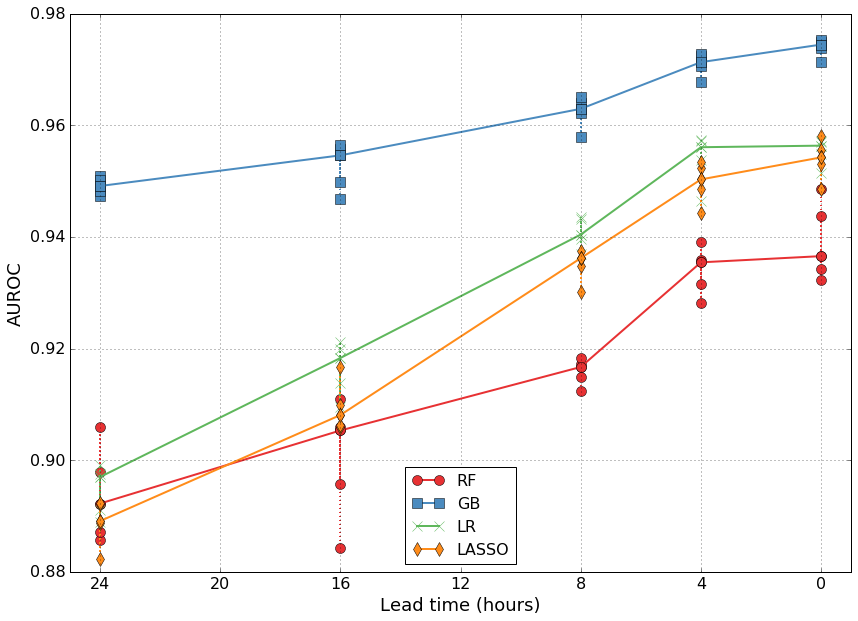

In [100]:
# plot a figure of the results
marker = ['o','s','x','d']
xi_str = ['Td=00','Td=04','Td=08','Td=16','Td=24']
xi = [int(x[-2:]) for x in xi_str]

plt.figure(figsize=[14,10])
for m, mdl in enumerate(models):
    all_score = list()
    for i, x in enumerate(xi_str):
        curr_score = results_all[x][mdl]

        plt.plot(xi[i] * np.ones(len(curr_score)), curr_score,
                marker=marker[m], color=col[m],
                markersize=10, linewidth=2, linestyle=':')

        all_score.append(np.median(curr_score))
        
    # plot a line through the mean across all evaluations

    plt.plot(xi, all_score,
            marker=marker[m], color=col[m],
            markersize=10, linewidth=2, linestyle='-',
            label=pretty_labels[mdl])

plt.gca().set_xticks(np.linspace(0,24,7))
plt.gca().set_xlim([-1,25])
plt.gca().invert_xaxis()
plt.legend(loc='lower center',fontsize=16)
plt.xlabel('Lead time (hours)',fontsize=18)
plt.ylabel('AUROC',fontsize=18)

ax = plt.gca()

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 

plt.grid()
#plt.savefig('auroc_over_time_dw24.pdf')
plt.show()

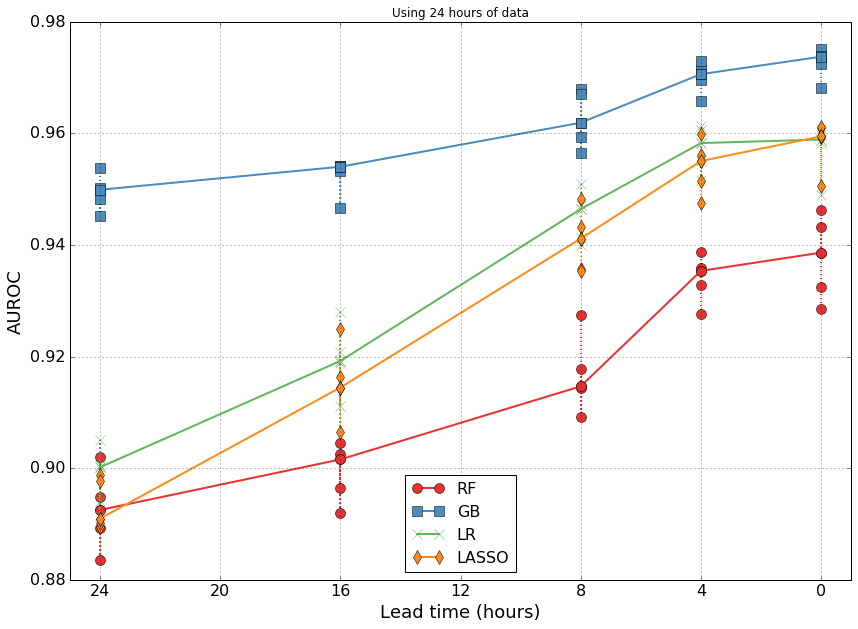

In [102]:
# plot a figure of the results
marker = ['o','s','x','d']
xi_str = ['24hr Td=00','24hr Td=04','24hr Td=08','24hr Td=16','24hr Td=24']
xi = [int(x[-2:]) for x in xi_str]

plt.figure(figsize=[14,10])
for m, mdl in enumerate(models):
    all_score = list()
    for i, x in enumerate(xi_str):
        curr_score = results_all[x][mdl]

        plt.plot(xi[i] * np.ones(len(curr_score)), curr_score,
                marker=marker[m], color=col[m],
                markersize=10, linewidth=2, linestyle=':')

        all_score.append(np.median(curr_score))
        
    # plot a line through the mean across all evaluations

    plt.plot(xi, all_score,
            marker=marker[m], color=col[m],
            markersize=10, linewidth=2, linestyle='-',
            label=pretty_labels[mdl])

plt.gca().set_xticks(np.linspace(0,24,7))
plt.gca().set_xlim([-1,25])
plt.gca().invert_xaxis()
plt.legend(loc='lower center',fontsize=16)
plt.xlabel('Lead time (hours)',fontsize=18)
plt.ylabel('AUROC',fontsize=18)

ax = plt.gca()

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 

plt.grid()
plt.title('Using 24 hours of data')
#plt.savefig('auroc_over_time_dw24.pdf')
plt.show()

## TODO

Repeat the same experiment as above, but this time, let's train a model with the outcome "did the patient die in the next 24 hours?"